# Waterquality example notebook

This notebook presents how to use the `waterquality` package, that is an extension for the `waterdetect` package for creating water quality maps based on inversion algorithms. 

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# First, make sure waterquality and waterdetect are correctly installed
# %pip install waterdetect
# pip install git+https://github.com/cordmaur/WaterQuality.git@main

from waterquality import DWWaterQuality

## Config files

Both `waterdetect` and `waterquality` need the config files (.ini) to be set before launching. Samples for these files can be found in the `tests/aux_data` folder. <br>
We will point to them:

In [2]:
from pathlib import Path
auxdata = Path('../tests/aux_data')

wd_ini = auxdata/'WaterDetect.ini'
wq_ini = auxdata/'WaterQuality.ini'

assert wq_ini.exists() and wd_ini.exists()


## Creating WaterQuality instance

In [3]:
from waterquality import DWWaterQuality

wq = DWWaterQuality(
    input_folder='d:/images/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741.SAFE',
    output_folder='d:/images/output',
    shape_file='d:/images/shp/22KEV.shp',
    product='S2_S2COR',
    config_file=wd_ini,
    config_wq=wq_ini,
    single_mode=True,
)

Initializing waterquality package (version=1.1.2)
Waterdetect version: 1.5.12
Trying to locate the proj.db inside GDAL.
Loading configuration file ..\tests\aux_data\WaterQuality.ini
File ..\tests\aux_data\WaterQuality.ini verified.
Loading configuration file ..\tests\aux_data\WaterDetect.ini
File ..\tests\aux_data\WaterDetect.ini verified.
Folder d:/images/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741.SAFE verified.
File d:/images/shp/22KEV.shp verified.
Folder d:/images/output verified.


## Create the inversion function

Before launching the processing, it is necessary to create the functions that will be responsible for inverting from the spectral signature to actual water quality parameters. <br>
These functions can be found in the literature, and they will depend on various factors such as water type, satellite sensor, atmospheric conditions, among others.

Once the correct function is selected, it is necessary to inform `waterquality` how to perform the inversion. You can inform more than one function for different parameters, for example, or to test different functions in the same area. <br>
The functions shall be informed in a dictionary containing {'name f1': function 1, 'name f2': function 2, ...}

Bellow is an example using the SPM algorithm proposed by Nechad et al. (2010).

OBS: The function will receive the following parameters:

The function can use any band available in the satellite. The only requirement is that it uses the same name in the arguments that `waterdetect` uses internally to refer to that band. So, before writing the inversion function, check the bands available for the satellite, that are informed in the `InputOutput` module from `waterdetect`. To simplify the calculation of the quality parameter, all the bands will be rescaled to the same shape, as defined in the `reference_band` in the config file `WaterDetect.ini`.

In [4]:
from waterdetect.InputOutput import DWLoader

# select the product
product = 'S2_S2COR'    # or S2_THEIA, L8_USGS, S2_L1C, L8_L1C

# print the bands with the internal waterdetect names
print(DWLoader.satellite_Dict['S2_S2COR'])

{'bands_names': {'Blue': 'B02_10m', 'Green': 'B03_10m', 'Red': 'B04_10m', 'Mir': 'B11_20m', 'Mir2': 'B12_20m', 'RedEdg1': 'B05_20m', 'RedEdg2': 'B06_20m', 'RedEdg3': 'B07_20m', 'Nir': 'B08_10m', 'Nir2': 'B8A_20m'}, 'suffix': '.jp2', 'string': '', 'metadata': '*MTD_TL.xml', 'subdir': 'GRANULE/*/IMG_DATA', 'recursive': True}


In [5]:
def tsm(Red=1):
    a = 493.65
    b = 1.16
    c = 0.188
    tsm = a * Red / (1 - (Red/c)) + b
    return tsm

In [6]:
functions = {
    'SPM_Nechad': {
        'function': tsm,
        'units': 'mg/l'
    }
    # Here you can add another quality function
}


In [7]:
wq.run_water_quality(
    inversion_functions=functions
)

Starting WaterDetection version: 1.5.12
Opening image in folder d:\images\22KEV\S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741.SAFE
Retrieving bands for product S2_S2COR
35 were found:
Loading band: Blue
Loading band: Green
Loading band: Red
Loading band: Mir
Loading band: Mir2
Loading band: RedEdg1
Loading band: RedEdg2
Loading band: RedEdg3
Loading band: Nir
Loading band: Nir2
Invalid pixels (0.0001303785886416148) < maximum (0.95).
Saving final MASK
Saving image: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741_invalid_mask.tif
Calculating water mask in single mode. Just the first band_combination is processed
Calculating clusters for the following combination of bands:
['mndwi', 'ndwi', 'Mir2']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Selection of best number of clusters using Calinski-Harabasz Index:
k=2 :Calinski_harabaz index=16833.524977553854
k=3 :Calinski_harabaz index=8425.920660045012
Applying clusters based naive bayes classifier
Assgnin 1 to cluster_id 0
Skipping cluster_id 0
Saving image: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/AC_NB_CM_mndwindwiMir2/AC_NB_CM_mndwindwiMir2_water_mask.tif
Saving image: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/AC_NB_CM_mndwindwiMir2/AC_NB_CM_mndwindwiMir2_clusters.tif
Saving image: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/AC_NB_CM_mndwindwiMir2/AC_NB_CM_mndwindwiMir2_water_mask_rgb.tif
Creating pdf file: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/AC_NB_CM_mndwindwiMir2/AC_NB_CM_mndwindwiMir2_water_mask_rgb.pdf
Saving image: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741

Saving image: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/SPM_Nechad.tif
Saving image: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/SPM_Nechad_rgb.tif
Creating pdf file: d:/images/output/22KEV/S2A_MSIL2A_20210706T133231_N0301_R081_T22KEV_20210706T172741/SPM_Nechad_rgb.pdf


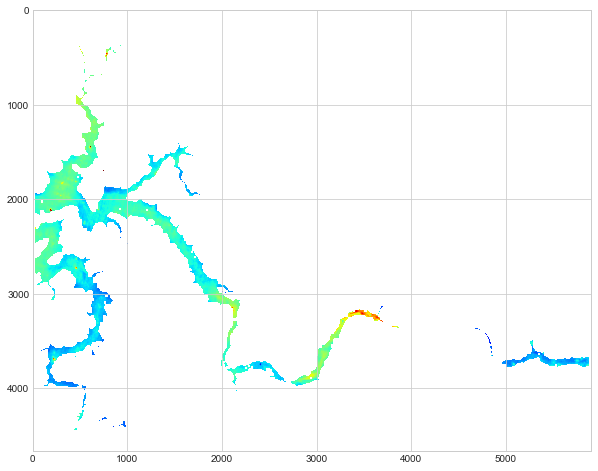

In [122]:
wq.plot_param('SPM_Nechad', cmap='jet', vmin=5, vmax=20)

If report is true in WaterDetect.ini, the water quality map will be displayed there:

If you want to acess the values directly from the notebook:

In [14]:
wq.quality_parameters

{'SPM_Nechad': array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32)}